# Modeling and Inferential Analysis

In this section we're going to look at the predictive power of certain variables by fitting a logistic regression base model as well as RandomForests to understand which features are most important.

This is different from our statistical tests above that are looking at a Hypothesis and decide whether or not the result is very unlikely to have happened by chance but rather this analysis helps us decide whether or not it could be beneficial to increase model complexity by using a feature due to its predictive power [https://statisticalhorizons.com/wp-content/uploads/GOFForLogisticRegression-Paper.pdf](https://statisticalhorizons.com/wp-content/uploads/GOFForLogisticRegression-Paper.pdf). 

This is always a trade-off as increasing our model complexity could lead to better results on our data but also makes a model prone to overfitting (e.g. a famous example of this is neural networks classifing dogs and wolves. Instead of learning the difference between dogs and wolves using their characteristics they used the surrounding environment, i.e. snow = wolf and dog = grass) [https://arxiv.org/abs/1602.04938](https://arxiv.org/abs/1602.04938).

In [838]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']
colorsP = colorsP[::-1]

plt.rcParams['figure.figsize'] = (10,6)

train = pd.read_csv('../data/processed/train.csv',sep='\t',parse_dates=['date','entry_date','exit_date','peak_date','max_leap_date']).set_index(['artist','title'])

In [839]:
features = ['acousticness','loudness','instrumentalness','danceability','valence','energy','tempo','duration_ms','time_signature','key','mode']
predictor = ['hit']

In [840]:
features_with_target = ['hit','danceability', 'energy', 'key','mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms','time_signature']

In [841]:
from sklearn.model_selection import train_test_split

Xy_train = train.loc[:,features + predictor].dropna()
X = Xy_train.drop('hit',axis=1)
y = Xy_train['hit']

X_tune, X_hold, y_tune, y_hold = train_test_split(X, y, test_size=0.33, random_state=42)
print(len(X_tune.T))
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.33, random_state=42)

11


In [842]:
from sklearn.preprocessing import StandardScaler

def scale_data(X_train,X_test):
    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, scaler

X_train, X_test, scaler = scale_data(X_train, X_test)

LR Scores:  [0.67249887 0.65597434 0.66411479 0.69004744 0.66779966]
Mean ROC AUC Score: 0.6700870198849793
LR Score Range: 0.0341


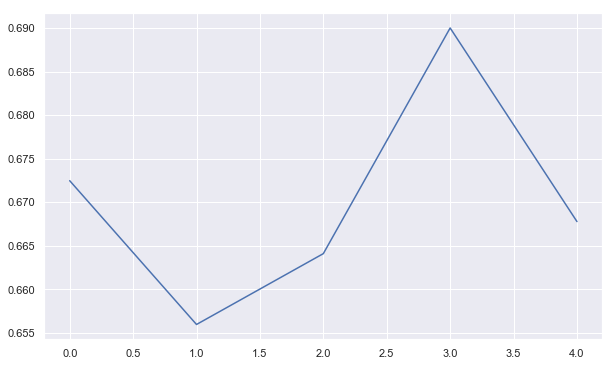

In [843]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def run_lr(X_train,y_train):
    lr = LogisticRegression(solver='lbfgs')
    
    lr_scores = cross_val_score(lr,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='roc_auc')
    
    print('LR Scores: ', lr_scores)
    print('Mean ROC AUC Score: {}'.format(lr_scores.mean()))
    print('LR Score Range: {}'.format(round(lr_scores.max() - lr_scores.min(),4)))
    _ = plt.plot(np.arange(len(lr_scores)),lr_scores)

run_lr(X_train,y_train)

Using the Baseline model and all features available to us we can see quite some variability in the ROC AUC Score. This usually indicates overfitting. Let's see if we can reduce that overfitting by reducing the dimensionality of the problem.

### Check for Collinearity

Collinearity of features can cause models to be unstable and overemphasizes certain features among other issues.

In [844]:
tune = pd.concat([X_tune,y_tune.astype(int)],axis=1)
tune.head()

,,acousticness,loudness,instrumentalness,danceability,valence,energy,tempo,duration_ms,time_signature,key,mode,hit
artist,title,,,,,,,,,,,,
Nicky Jam + Ozuna,Te Robaré,0.241,-3.572,0.000045,0.673,0.7970,0.752,175.997,201818.0,4.0,2.0,0.0,0
K.T. Oslin,"Dr., Dr.",0.414,-11.299,0.000451,0.699,0.6570,0.449,101.034,207520.0,4.0,5.0,1.0,0
Jorge Celedón + Binomio de Oro de América,Olvídala,0.139,-5.136,0.000000,0.533,0.6150,0.727,132.295,306307.0,4.0,2.0,1.0,0
Acoustic Alchemy,Caravan Of Dreams,0.973,-14.986,0.807000,0.609,0.5140,0.175,100.261,181000.0,3.0,9.0,0.0,0
Nataural,Florida Rain Storm,0.002,-20.970,0.759000,0.211,0.0358,0.774,54.387,170922.0,4.0,5.0,0.0,0


In [845]:
# find correlations to target
corr_matrix = tune.corr().abs()

corr_matrix.hit.sort_values(ascending=False)

hit                 1.000000
instrumentalness    0.244099
loudness            0.222210
acousticness        0.205973
danceability        0.193349
energy              0.182371
valence             0.172448
time_signature      0.090317
duration_ms         0.057462
mode                0.033351
tempo               0.032770
key                 0.002288
Name: hit, dtype: float64

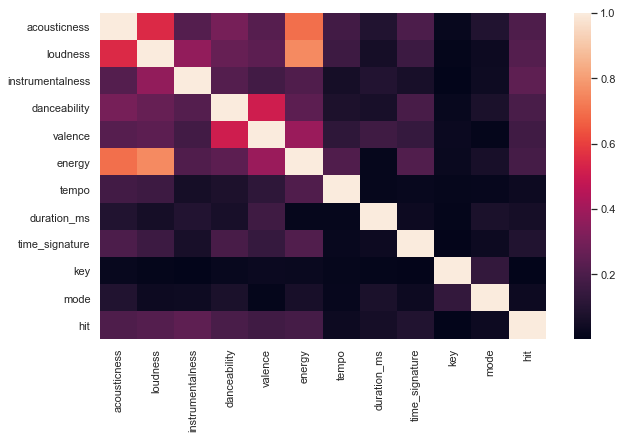

In [846]:
sns.heatmap(corr_matrix)
plt.show;

In [847]:
corr_matrix.energy[:2]

acousticness    0.696114
loudness        0.758092
Name: energy, dtype: float64

We can see that Energy has a medium to strong correlation with acousticness and loudness. However, there might still be information in Energy as a feature, which is why we'll leave it in and hope that the issue can be resolved using PCA in the next step.

There is also a medium correlation between loudness and acousticness.

In [848]:
# Remove energy from features
corr_matrix.loudness[:1]

acousticness    0.549694
Name: loudness, dtype: float64

For now we'll keep this feature in as it might hold valuable information anyways. Any correlation here will be removed in the PCA step.

We also can see that mode, tempo and key have almost no correlation with our target variable as could be witnessed in the exploratory data analysis as well, which is why we'll remove these features.

In [849]:
# Remove more features
tune_clean = tune.drop(['tempo','mode','key'],axis=1)

LR Scores:  [0.67114194 0.65504814 0.66420583 0.69053841 0.66769379]
Mean ROC AUC Score: 0.6697256215795722
LR Score Range: 0.0355


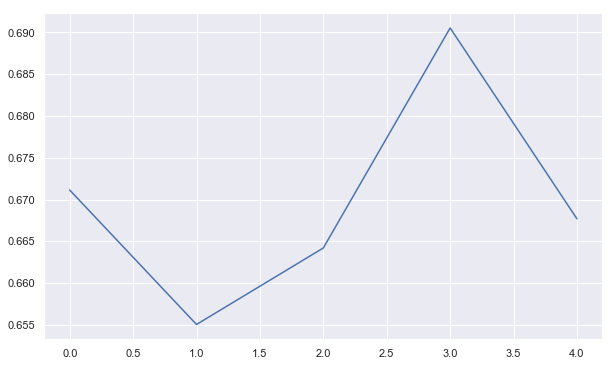

In [850]:
X_tune_cl = tune_clean.drop('hit', axis=1)
y_tune_cl = tune_clean['hit']
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_tune_cl, y_tune_cl, test_size=0.33, random_state=42)

X_train_cl, X_test_cl, scaler_cl = scale_data(X_train_cl,X_test_cl)

run_lr(X_train_cl,y_train_cl)

Removing 5 features from the model has not significantly affected the Cross Validation output. There was a slight increase of 0.17 in the LR Score Range but we have been able to remove collinear features as well as some features with very low correlation metrics.

### Dimensionality Reduction

After we've selected our relevant features we can now use PCA to reduce our features to their intrinsic dimensions.

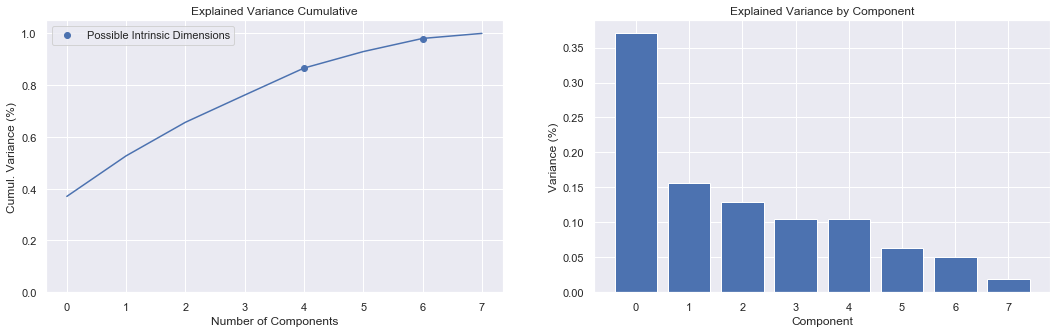

In [851]:
from sklearn.decomposition import PCA

#Fitting the PCA algorithm with our Data
pca = PCA()
pca.fit(X_train_cl)

#Plotting the Cumulative Summation of the Explained Variance
fig, ax = plt.subplots(1,2,figsize=(18,5))

plt.subplot(1,2,1)
_ = plt.plot(np.cumsum(pca.explained_variance_ratio_))
_ = plt.xlabel('Number of Components')
_ = plt.ylabel('Cumul. Variance (%)') #for each component
_ = plt.ylim(0,1+0.05)
_ = plt.title('Explained Variance Cumulative')
_ = plt.scatter([6,4],[0.98,0.866],label='Possible Intrinsic Dimensions')
_ = plt.legend(loc='upper left')

plt.subplot(1,2,2)
_ = plt.bar(np.arange(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
_ = plt.xlabel('Component')
_ = plt.ylabel('Variance (%)') #for each component
_ = plt.title('Explained Variance by Component')

It's clear that our data has either 4 or 6 intrinsic dimensions as the explained variance drops at those points. To avoid overfitting we'll use 4 components.

In [852]:
pca4 = PCA(n_components=4)
X_train_reduced = pca4.fit_transform(X_train_cl)
X_test_reduced = pca4.transform(X_test_cl)

LR Scores:  [0.6507757  0.64367799 0.65027188 0.67643671 0.65280039]
Mean ROC AUC Score: 0.6547925357165497
LR Score Range: 0.0328


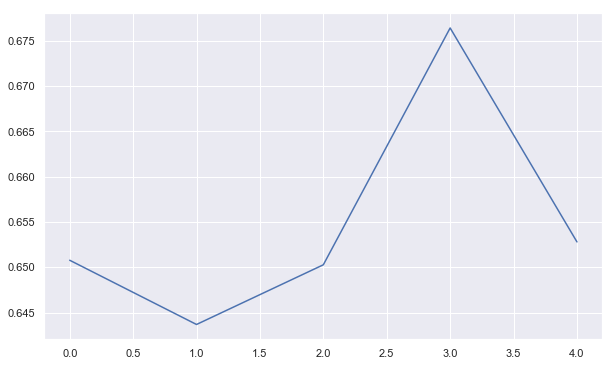

In [853]:
run_lr(X_train_reduced,y_train_cl)

Unfortunately, our gains in reducing the LR Score range are minimal. As expected we've also lost a little bit of overall ROC AUC score but that is almost negligible. Hopefully the model has gained some stability through this process. We'll now go on to optimizing parameters.

### Optimizing Hyperparameters

In this step we're using cross validation to optimize parameters over our tuning data.

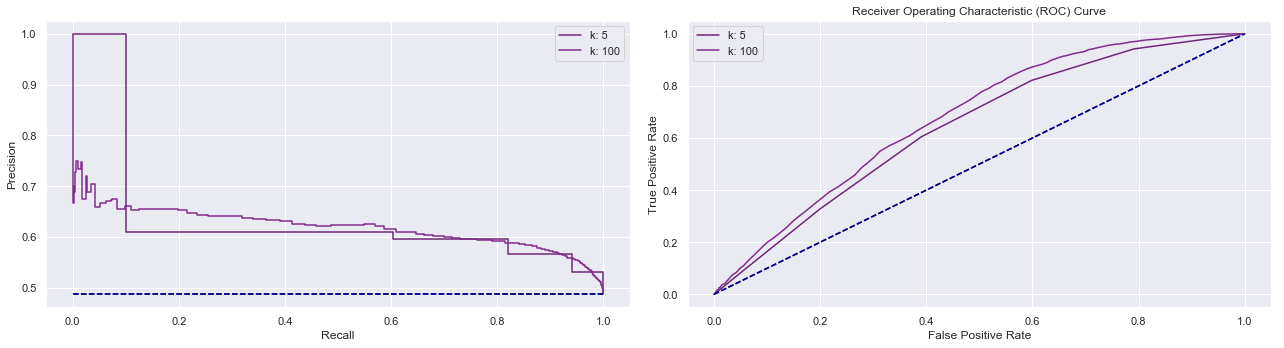

Max Precision-Recall AUC: 0.6193967664387775 at 100 estimators
Max ROC AUC: 0.6789251521786644 at 100 estimators


In [854]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

# The function
def plot_pr_curve(y_test,y_pred,hyperparameter,color,ax=False):
    precision,recall,threshold = precision_recall_curve(y_test,y_pred)
    
    if ax:
        _ = ax.step(recall,precision,label='k: {}'.format(hyperparameter),color=color)
        dumb = len(y_test[y_test>0])/len(y_test)
        _ = ax.plot([0,1],[dumb,dumb], color='darkblue', linestyle='--')
        _ = ax.set_xlabel('Recall')
        _ = ax.set_ylabel('Precision')
        
        ax.legend()
    else:
        _ = plt.step(recall,precision,label='k: {}'.format(hyperparameter),color=color)
        dumb = len(y_test[y_test>0])/len(y_test)
        _ = plt.plot([0,1],[dumb,dumb], color='darkblue', linestyle='--')
        _ = plt.xlabel('Recall')
        _ = plt.ylabel('Precision')
        
        plt.legend()
    
    pr_auc = auc(recall,precision)
    return pr_auc

# The ROC function
def plot_roc_curve(y_test, y_pred, hyperparameter,color,ax=False):  
    """
        Plot Roc Curve using predictions or probabilities
    """
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    
    if ax:
        _ = ax.plot(fpr, tpr, label='k: {}'.format(hyperparameter),color=color)
        _ = ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        _ = ax.set_xlabel('False Positive Rate')
        _ = ax.set_ylabel('True Positive Rate')
        _ = ax.set_title('Receiver Operating Characteristic (ROC) Curve') 
        
        ax.legend()
    else:
        _ = plt.plot(fpr, tpr, label='k: {}'.format(hyperparameter),color=color)
        _ = plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        _ = plt.xlabel('False Positive Rate')
        _ = plt.ylabel('True Positive Rate')
        _ = plt.title('Receiver Operating Characteristic (ROC) Curve')
        
        plt.legend()
    
    roc_auc = roc_auc_score(y_test_cl,y_pred)
    return roc_auc

estimators = np.arange(0,200,100)
estimators[0] = 5
pr_aucs = np.empty(len(estimators))
roc_aucs = np.empty(len(estimators))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))

for i,k in enumerate(estimators):
    rf = RandomForestClassifier(n_estimators=k,random_state=42)
    rf.fit(X_train_reduced,y_train_cl)

    y_test_pred = rf.predict_proba(X_test_reduced).T[1]
    pr_auc = plot_pr_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax1)
    roc_auc = plot_roc_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax2)
    pr_aucs[i] = pr_auc
    roc_aucs[i] = roc_auc
    
_ = plt.tight_layout()

plt.show()

best_pr = pr_aucs.max()
best_pr_k = estimators[np.where(pr_aucs == best_pr)[0]][0]
best_roc_auc = roc_aucs.max()
best_roc_auc_k = estimators[np.where(roc_aucs == best_roc_auc)[0]][0]

print("Max Precision-Recall AUC: {} at {} estimators".format(best_pr,best_pr_k))
print("Max ROC AUC: {} at {} estimators".format(best_roc_auc,best_roc_auc_k))

In [855]:
# Create RandomForest Classifier with Best Precision Recall Hyperparameter
rf_best = RandomForestClassifier(n_estimators=best_pr_k,random_state=42)
_ = rf_best.fit(X_train_reduced,y_train_cl)

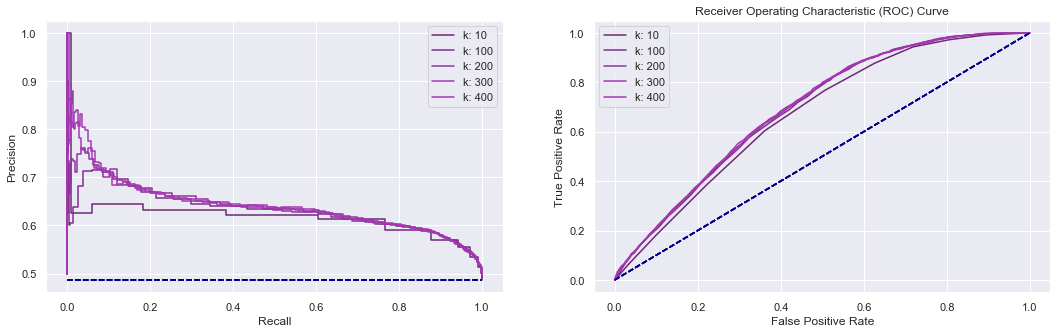

<Figure size 1296x576 with 0 Axes>

Max Precision-Recall AUC: 0.6420348688671889 at 300 neighbors
Max ROC AUC: 0.6949658019599748 at 300 neighbors


In [856]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = np.arange(0,500,100)
neighbors[0] = 10
pr_aucs = np.empty(len(neighbors))
roc_aucs = np.empty(len(neighbors))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))

fig = plt.figure(figsize=(18,8))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_reduced,y_train_cl)

    y_test_pred = knn.predict_proba(X_test_reduced).T[1]
    pr_auc = plot_pr_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax1)
    roc_auc = plot_roc_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax2)
    pr_aucs[i] = pr_auc
    roc_aucs[i] = roc_auc
    
_ = plt.tight_layout()

plt.show()

best_pr = pr_aucs.max()
best_pr_k = neighbors[np.where(pr_aucs == best_pr)[0]][0]
best_roc_auc = roc_aucs.max()
best_roc_auc_k = neighbors[np.where(roc_aucs == best_roc_auc)[0]][0]

print("Max Precision-Recall AUC: {} at {} neighbors".format(best_pr,best_pr_k))
print("Max ROC AUC: {} at {} neighbors".format(best_roc_auc,best_roc_auc_k))

In [857]:
knn_best = KNeighborsClassifier(n_neighbors=best_pr_k)
_ = knn_best.fit(X_train_reduced,y_train_cl)

In [858]:
from sklearn.metrics import log_loss,accuracy_score, precision_recall_fscore_support

def get_eval(clf,X,y_true):
    y_pred = clf.predict(X)
    accuracy = (np.nan,accuracy_score(y_true,y_pred))

    y_pred_proba = clf.predict_proba(X)
    logloss = (np.nan,log_loss(y_true,y_pred_proba))
    
    # Beta shifts the weight toward recall by a factor of beta (e.g. beta=0.5 -> recall is half as important as precision)
    beta = 1
    precision, recall, f1, support = precision_recall_fscore_support(y_true,y_pred,beta=beta)

    scores = ['accuracy','logloss','precision','recall','f1 beta={}'.format(beta),'support']
    labels = list(clf.classes_)
    display(pd.DataFrame([accuracy,logloss,precision,recall,f1,support],columns=labels,index=scores))

get_eval(rf_best,X_test_reduced,y_test_cl)

,0,1
accuracy,NaN,0.624383
logloss,NaN,0.652864
precision,0.647572,0.604133
recall,0.588235,0.662493
f1 beta=1,0.616479,0.631968
support,3536.000000,3354.000000


In [859]:
get_eval(knn_best,X_test_reduced,y_test_cl)

,0,1
accuracy,NaN,0.643832
logloss,NaN,0.620317
precision,0.733794,0.598339
recall,0.480204,0.816339
f1 beta=1,0.580513,0.690542
support,3536.000000,3354.000000


We can see that the KNeighbors classifier has slightly lower precision meaning more songs that are tagged as a Hit turn out not to be hits but the difference in precision is negligible compared to the performance of KNeighbors in terms of recall. KNeighbors is able to retrieve ~82% of all Hits.

# Validation

In the first step of this notebook we've created a Hold out set to validate that our model also works on unseen data (i.e. can be generalized). We're now looking at how KNeighbors performs on this Hold out set.

In [870]:
hold = pd.concat([X_hold,y_hold.astype(int)],axis=1)
hold_clean = hold.drop(['tempo','mode','key'],axis=1)
X_hold_cl = hold_clean.drop('hit', axis=1)
y_hold_cl = hold_clean['hit'].astype(bool)
X_hold_scaled = scaler_cl.transform(X_hold_cl)
X_hold_reduced = pca4.transform(X_hold_scaled)

get_eval(knn_best, X_hold_reduced, y_hold_cl)

,0,1
accuracy,NaN,0.650817
logloss,NaN,0.619808
precision,0.728431,0.611567
recall,0.486748,0.816618
f1 beta=1,0.583556,0.699372
support,5169.000000,5115.000000


In [871]:
get_eval(rf_best, X_hold_reduced, y_hold_cl)

,0,1
accuracy,NaN,0.638370
logloss,NaN,0.654292
precision,0.652375,0.626312
recall,0.600503,0.676637
f1 beta=1,0.625365,0.650503
support,5169.000000,5115.000000
